# Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump
import seaborn as sns
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

We are going to do the same as in the breast cancer notebook

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/software_defect.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/software_defect.parquet')

In [5]:
y_train = train.defects
X_train = train.drop(columns=['defects'])

In [6]:
y_validation = validation.defects
X_validation = validation.drop(columns=['defects'])

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
lr = LogisticRegression(penalty=None)
lr_l2 = LogisticRegression()
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
lr_en1 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25, max_iter=500)
lr_en2 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=500)
lr_en3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.75, max_iter=500)

In [10]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [11]:
metrics = classification(models_list, names_list, '../../../data/metrics/software_defect/logistic_regression.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
LR,0.325209,0.779566,0.780034,0.059992
LR_l2,0.306167,0.779563,0.780032,0.060120
LR_l1,1.331464,0.779573,0.780040,0.059856
LR_en_0.25,11.431395,0.779566,0.780035,0.060178
LR_en_0.5,13.824787,0.779564,0.780033,0.060166
LR_en_0.75,14.015808,0.779563,0.780033,0.060371


In [19]:
sparsity_lr = np.mean(lr.coef_.ravel() == 0) * 100
sparsity_lr_l2 = np.mean(lr_l2.coef_.ravel() == 0) * 100
sparsity_lr_l1 = np.mean(lr_l1.coef_.ravel() == 0) * 100
sparsity_lr_en1 = np.mean(lr_en1.coef_.ravel()) * 100
sparsity_lr_en2 = np.mean(lr_en2.coef_.ravel()) * 100
sparsity_lr_en3 = np.mean(lr_en3.coef_.ravel()) * 100

print("Sparsity without penalty term:", round(sparsity_lr, 2), '%')
print("Sparsity with L2 penalty:", round(sparsity_lr_l2, 2), '%')
print("Sparsity with L1 penalty:", round(sparsity_lr_l1, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.25:", round(sparsity_lr_en1, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.5:", round(sparsity_lr_en2, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.75:", round(sparsity_lr_en3, 2), '%')

Sparsity without penalty term: 0.0 %
Sparsity with L2 penalty: 0.0 %
Sparsity with L1 penalty: 0.0 %
Sparsity with ElasticNet penalty and l1 ratio=0.25: 4.42 %
Sparsity with ElasticNet penalty and l1 ratio=0.5: 4.42 %
Sparsity with ElasticNet penalty and l1 ratio=0.75: 4.42 %


We are choosing **LR** as the best model because we get same results and neither l1 nor l2 discard any feature.

In [12]:
test =  pd.read_parquet('../../../data/model_input/test_sets/software_defect.parquet')

In [13]:
y_test = test.defects
X_test = test.drop(columns=['defects'])

In [14]:
retrain = pd.concat([train, validation])

In [15]:
y_retrain = retrain.defects
X_retrain = retrain.drop(columns=['defects'])

In [16]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [17]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [25]:
model = LogisticRegression(penalty=None).fit(X_retrain_scaled, y_retrain)

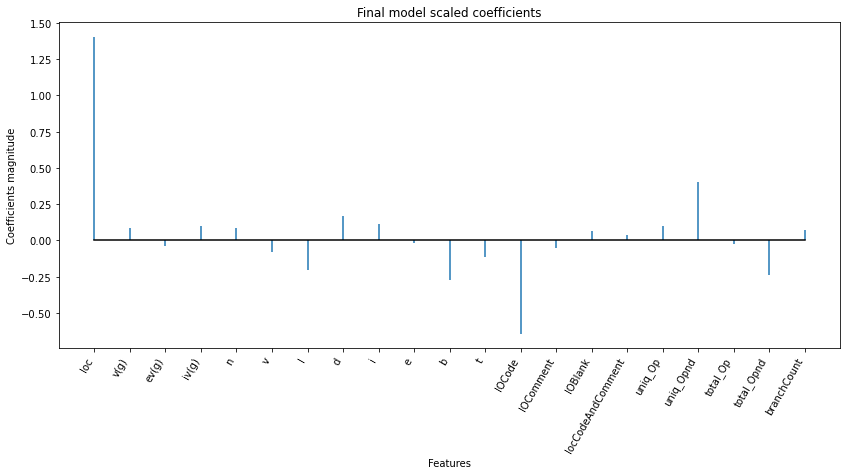

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=60, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients');

In [27]:
test_pred = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.7843


Let's see if we can get better AUC by changing something

In [23]:
new_train = pd.DataFrame(X_retrain_scaled, columns=X_retrain.columns)

In [36]:
new_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [31]:
cols_to_fit = ['loc', 'lOCode', 'uniq_Op']

In [32]:
new_model = LogisticRegression(penalty=None).fit(new_train[cols_to_fit], y_retrain)

In [37]:
print('AUC:', round(roc_auc_score(y_test, new_model.predict_proba(new_test[cols_to_fit])[:, 1]), 4))

AUC: 0.7801


In [39]:
cols_to_fit2 = ['loc', 'lOCode', 'uniq_Op', 'b', 'total_Opnd']

In [40]:
new_model2 = LogisticRegression(penalty=None).fit(new_train[cols_to_fit2], y_retrain)

In [41]:
print('AUC:', round(roc_auc_score(y_test, new_model2.predict_proba(new_test[cols_to_fit2])[:, 1]), 4))

AUC: 0.7806


We still choosing the final model with every feature as the best one

In [42]:
dump(model, 'best_logistic_regression.joblib')

['best_logistic_regression.joblib']

In [43]:
with open('../../../data/metrics/software_defect/final_AUC.txt', 'a') as f:
    f.write('\nLR, '+ str(auc))